In [3]:
%pylab inline
from scipy import interpolate
from scipy import optimize
import tqdm
import ipywidgets as ipw

Populating the interactive namespace from numpy and matplotlib


In [2]:
#U = 0 # coulob repulsion
#ne = 1.6 # number of electrons per unit cell/ occupation number
# The occupation number independent part of the Hamiltonina
nk = 200
kbt =.01
delta=.9
kran = linspace(-pi,pi,nk,endpoint=False)
kx,ky = meshgrid(kran,kran)
kx = kx.flatten()
ky = ky.flatten()
gamma = -(1+exp(-1j*2*kx)+exp(-1j*(kx-ky))+exp(-1j*(kx+ky)))
H0k = zeros((len(gamma),2,2),dtype=complex)
H0k[:,0,1] = gamma
H0k[:,1,0] = conj(gamma)


In [3]:
# this generates eigen values and eigen vectors and returns them 
def make_spectr(U,n1,n2):
    Hk = H0k.copy()
    Hk[:,0,0] = U*n1
    Hk[:,1,1] = U*n2
    return eigh(Hk)

def FD(Energy,kbt):
    return 1/(1+exp(Energy/kbt))


In [4]:
# a function that would find the new occupation number for each site, it needs to be run in a self consistency loop, this vergion can be used with fixed point f'n     
def self_consistency2(ns,U,ne,kbt):  # (U,ns,ne)
        n1_do,n2_do,n1_up,n2_up = ns  

        vals_up,vects_up = make_spectr(U,n1_do,n2_do)
        vals_do,vects_do = make_spectr(U,n1_up,n2_up)
        num_of_k_points = len(vals_up)

        
        #########################################################################
        # get new spectrum and wavefunctions
        # vals_up[ik,i] the i-th eigenvalue of up electrons at the ik-th k point
        # vecs_up[ik,site,i] the i-th wavefunction of up electrons at the ik-th k point evaluated at site "site".
 
        
        rho,eran = histogram(array([vals_up,vals_do]).flatten(),1000,density=True)
        rho = convolve(rho,hamming(10),mode='same')/5 # some additional smoothing
        NE = cumsum(rho)*diff(eran)[0]
        mu = interpolate.interp1d(NE*4,eran[:-1],fill_value="extrapolate")
        

        
        
        n1_do_new = (sum(abs(vects_do[:, 0, 0])**2*FD(vals_do[:,0]-mu(ne),kbt))+
                    sum(abs(vects_do[:, 0, 1])**2*FD(vals_do[:,1]-mu(ne),kbt)))/num_of_k_points
                                                                                                                            #i should find fermi function of energy - mu
        n2_do_new = (sum(abs(vects_do[:, 1, 0])**2*FD(vals_do[:,0]-mu(ne),kbt))+
                    sum(abs(vects_do[:, 1, 1])**2*FD(vals_do[:,1]-mu(ne),kbt)))/num_of_k_points
        
        n1_up_new = (sum(abs(vects_up[:, 0, 0])**2*FD(vals_up[:,0]-mu(ne),kbt))+
                    sum(abs(vects_up[:, 0, 1])**2*FD(vals_up[:,1]-mu(ne),kbt)))/num_of_k_points
        
        n2_up_new =  (sum(abs(vects_up[:, 1, 0])**2*FD(vals_up[:,0]-mu(ne),kbt))+
                    sum(abs(vects_up[:, 1, 1])**2*FD(vals_up[:,1]-mu(ne),kbt)))/num_of_k_points
        
        if ((n1_up > n1_do) and (n1_up_new < n1_do_new)):
            n1_up_new = n1_do_new
        if ((n2_up > n2_do) and (n2_up_new < n2_do_new)):
            n2_up_new = n2_do_new
        if ((n1_do > n1_up) and (n1_do_new < n1_up_new)):
            n1_do_new = n1_up_new
        if ((n2_do > n2_up) and (n2_do_new < n2_up_new)):
            n2_do_new = n2_up_new
            
        
        ns_new = array([n1_do_new ,n2_do_new, n1_up_new, n2_up_new])
        ns_new = (ns_new * ne)/ sum(ns_new)

        # this is a comment
       
        return ns_new - ns

In [5]:
def tot_ener(ns,U,ne,kbt):
        n1_do,n2_do,n1_up,n2_up = ns  

        vals_up,vects_up = make_spectr(U,n1_do,n2_do)
        vals_do,vects_do = make_spectr(U,n1_up,n2_up)
        num_of_k_points = len(vals_up)

        
        #########################################################################
        # get new spectrum and wavefunctions
        # vals_up[ik,i] the i-th eigenvalue of up electrons at the ik-th k point
        # vecs_up[ik,site,i] the i-th wavefunction of up electrons at the ik-th k point evaluated at site "site".
 
        
        rho,eran = histogram(array([vals_up,vals_do]).flatten(),1000,density=True)
        rho = convolve(rho,hamming(10),mode='same')/5 # some additional smoothing
        NE = cumsum(rho)*diff(eran)[0]
        mu = interpolate.interp1d(NE*4,eran[:-1],fill_value="extrapolate")
        
        energy = sum(vals_up[:,0]*FD(vals_up[:,0]-mu(ne),kbt)) +\
                 sum(vals_up[:,1]*FD(vals_up[:,1]-mu(ne),kbt)) +\
                 sum(vals_do[:,0]*FD(vals_do[:,0]-mu(ne),kbt)) +\
                 sum(vals_do[:,1]*FD(vals_do[:,1]-mu(ne),kbt)) +\
                 -(U * num_of_k_points*((n1_do*n1_up)+(n2_do*n2_up)))
        
        return energy

In [6]:

tot_energy_anti = []
for ne in tqdm.tqdm_notebook(arange(0.1,2,.1)):
    nvals_anti = []
    for U in tqdm.tqdm_notebook((1/arange(.1,.35,.01))):
        n1_up_anti = (ne/4) + delta #occupation on site 1
        n1_do_anti = (ne/4) - delta
        n2_up_anti = (ne/4) - delta
        n2_do_anti = (ne/4) + delta
        nvals_anti.append(optimize.root(self_consistency2,
                                        [n1_do_anti,n2_do_anti, n1_up_anti,n2_up_anti ],
                                        args=(U,ne,kbt),
                                        method='broyden1',
                                        ))
    
    for U,i in zip((1/arange(.1,.35,.01)), range(0,26)):
         tot_energy_anti.append(tot_ener(nvals_anti[i].x,U,ne,kbt)/nk**2)
    

/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [7]:
tot_energy_ferro = []
for ne in tqdm.tqdm_notebook(arange(0.1,2,.1)):
    nvals_ferro = []
    for U in tqdm.tqdm_notebook((1/arange(.1,.35,.01))):
        n1_up_ferro = (ne/4) + delta #occupation on site 1
        n1_do_ferro = (ne/4) - delta
        n2_up_ferro = (ne/4) + delta
        n2_do_ferro = (ne/4) - delta
        nvals_ferro.append(optimize.root(self_consistency2,
                                        [n1_do_ferro,n2_do_ferro, n1_up_ferro,n2_up_ferro ],
                                        args=(U,ne,kbt),
                                        method='broyden1',
                                        ))
    
    for U,i in zip((1/arange(.1,.35,.01)), range(0,26)):
         tot_energy_ferro.append(tot_ener(nvals_ferro[i].x,U,ne,kbt)/nk**2)

/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [8]:
tot_energy_para = []
for ne in tqdm.tqdm_notebook(arange(0.1,2,.1)):
    n1_up_para = (ne/4)  #occupation on site 1
    n1_do_para = (ne/4) 
    n2_up_para = (ne/4) 
    n2_do_para = (ne/4)         


    for U,i in zip((1/arange(.1,.35,.01)), range(0,26)):
        record = []
        tot_energy_para.append(record)
        record.append(tot_ener([n1_do_para,n2_do_para, n1_up_para,n2_up_para ],U,ne,kbt)/nk**2)

/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/assem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [76]:
a = reshape(tot_energy_para,(19,25))
b = reshape(tot_energy_anti,(19,25))
c = reshape(tot_energy_ferro,(19,25))

@ipw.interact(i=(0,18))
def play(i):
    plot(arange(.1,.35,.01),a[i],'r-',label='PM')
    plot(arange(.1,.35,.01),b[i],'k--',label='AFM')
    #plot(arange(.1,.35,.01),c[i],'b:',label='FM')
    legend()

interactive(children=(IntSlider(value=9, description='i', max=18), Output()), _dom_classes=('widget-interact',…

In [65]:
para_anti = []
for i in range(0,19):
    para_anti.append(argmin(abs(a[i]-b[i])[:]))
para_ferro = []
for i in range(0,19):
    para_ferro.append(argmin(abs(a[i]-c[i])[:10]))
anti_ferro = []
for i in range(0,19):
    anti_ferro.append(argmin(abs(b[i]-c[i])[:10]))

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

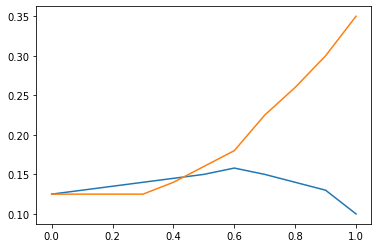

In [58]:
d = [.1.125,.125,.125,.14,.16,.18,.225,.26,.3,.35]
g = [.125,.13,.135,.14,.145,.15,.158,.15,.14,.13,.1]
c = g[::-1]
e = d[::-1]
plot(arange(0,1.1,.1),g)
plot(arange(0,1.1,.1),d)
plot(arange(1,2,.1),c)
plot(arange(1,2,.1),e)